In [1]:
import numpy as np 
import pandas as pd 

In [70]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

**Load data from csv files.**

Information about types of brain waves (especially low vs high): https://nhahealth.com/brainwaves-the-language/

In [4]:
sleepiness_df = pd.read_csv("C:/SEAN/GA Tech Academics/Grad/Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Sleepiness/Datasets/acquiredDataset.csv", header = 0)

In [5]:
sleepiness_df.head()

,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,classification
0,26,34,960462,277180,26575,27356,26575,13056,9126,2683,0
1,29,54,39145,28225,20172,39551,20172,9933,5237,4750,0
2,40,48,75410,43144,8601,13564,8601,11663,2515,3251,0
3,66,47,16057,41211,2534,34254,2534,27663,11396,2825,0
4,81,67,10304,47239,33158,47349,33158,16328,5298,5471,0


Drop the rightmost column of sleepiness_df, because we are more concerned with attention and meditation.

In [6]:
sleepiness_df = sleepiness_df.iloc[:, :-1]

In [7]:
print(sleepiness_df.shape)

(3735, 10)


In [8]:
sleepiness_df.head()

,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma
0,26,34,960462,277180,26575,27356,26575,13056,9126,2683
1,29,54,39145,28225,20172,39551,20172,9933,5237,4750
2,40,48,75410,43144,8601,13564,8601,11663,2515,3251
3,66,47,16057,41211,2534,34254,2534,27663,11396,2825
4,81,67,10304,47239,33158,47349,33158,16328,5298,5471


**Visualize the raw data.**

<Axes: >

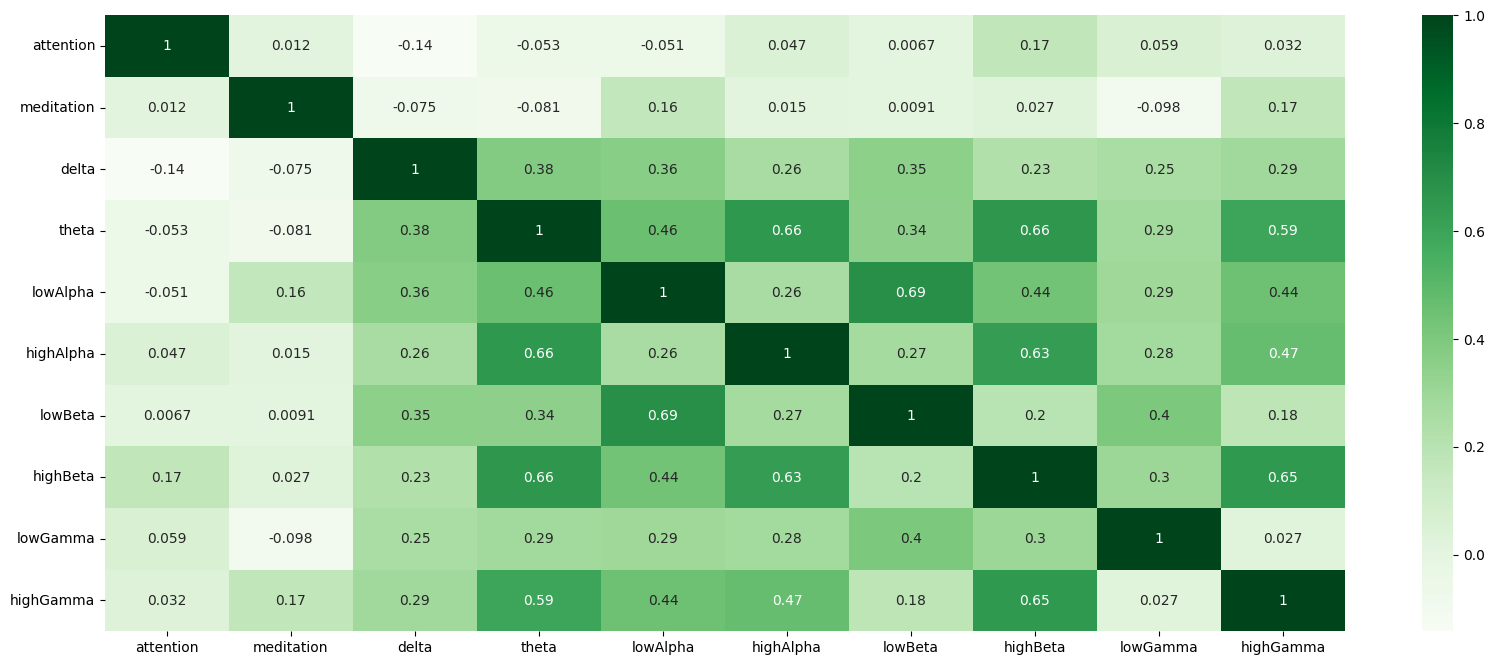

In [9]:
plt.figure(figsize=(20, 8))
sns.heatmap(sleepiness_df.corr(), cmap="Greens", annot=True)

**Data preprocessing:**

Helpful links about determining optimal polynomial order for regression:

https://aamir07.medium.com/polynomial-regression-with-k-fold-cross-validation-bc5275137546

We have two output variables we want to study- attention and meditation. We will handle each of them separately.

In [11]:
X = sleepiness_df.iloc[:, 2:]
X.head()

,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma
0,960462,277180,26575,27356,26575,13056,9126,2683
1,39145,28225,20172,39551,20172,9933,5237,4750
2,75410,43144,8601,13564,8601,11663,2515,3251
3,16057,41211,2534,34254,2534,27663,11396,2825
4,10304,47239,33158,47349,33158,16328,5298,5471


In [81]:
def perform_feature_selection(X: pd.DataFrame, y) -> pd.DataFrame:
    
    # Use recursive feature elimination to select the best features from X
    rfecv = RFECV(estimator = LinearRegression(), min_features_to_select = 1, scoring = 'neg_root_mean_squared_error', cv = 5)
    rfecv.fit(X, y)
    kept_columns = X.columns[rfecv.support_]
    
    print("kept columns:")
    print(kept_columns)
    return X.loc[:, kept_columns]

In [63]:
def k_folds_cross_validation(X: pd.DataFrame, y) -> int:
    training_errors = []
    cross_validation_errors = []

    for i in range(1, 8): # Experiment with degrees of 1 (linear) up to 7
        #print("i =", i)
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)
        linear_reg = LinearRegression(fit_intercept=False)
        model = linear_reg.fit(X_train, y_train)

        # Predict on test data and compute RMSE
        y_pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        training_errors.append(rmse)

        # Perform 5-fold cross-validation and compute mean RMSE
        cv = cross_validate(linear_reg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, return_train_score=True)
        #print(cv['test_score'])
        mean_cv_rmse = np.sqrt(np.abs(np.mean(cv['test_score'])))
        cross_validation_errors.append(mean_cv_rmse)

    # Visualize the training and cross-validation errors for each polynomial degree
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(range(1, 8), cross_validation_errors, label='Cross-Validation RMSE', marker='o')
    ax.set_xlabel('Polynomial Degree', fontsize=16)
    ax.set_ylabel('RMSE', fontsize=16)
    ax.set_title('Cross-Validation RMSE', fontsize=18)
    ax.legend(fontsize=12)
    plt.show()
    
    optimal_degree = np.argmin(cross_validation_errors) + 1  # Add 1 because degrees start at 1
    return optimal_degree

**Regression model for attention:**

In [64]:
y_attention = sleepiness_df.iloc[:, 0]
y_attention.head()

0    26
1    29
2    40
3    66
4    81
Name: attention, dtype: int64

In [82]:
X_attention_preprocessed = perform_feature_selection(X, y_attention)

kept columns:
Index(['theta', 'lowAlpha', 'highAlpha', 'lowBeta', 'highBeta', 'lowGamma'], dtype='object')


In [84]:
X_attention_preprocessed.head()

,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma
0,277180,26575,27356,26575,13056,9126
1,28225,20172,39551,20172,9933,5237
2,43144,8601,13564,8601,11663,2515
3,41211,2534,34254,2534,27663,11396
4,47239,33158,47349,33158,16328,5298


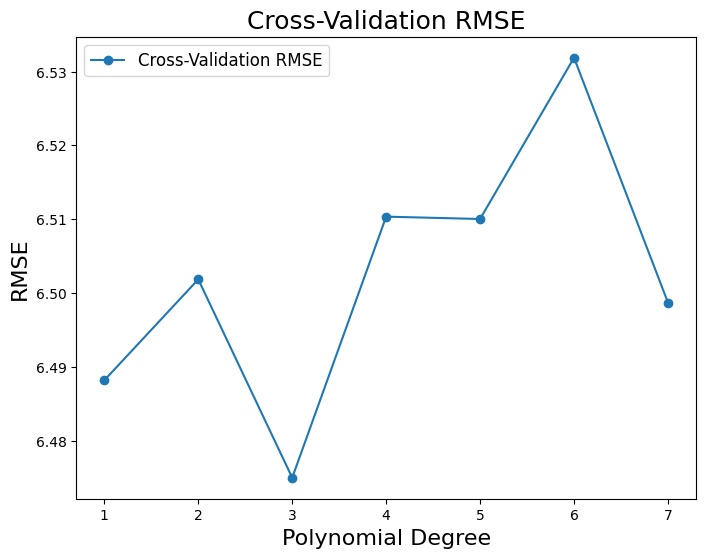

Optimal regression polynomial degree for attention: 3


In [85]:
optimal_attention_regression_degree = k_folds_cross_validation(X_attention_preprocessed, y_attention)
print("Optimal regression polynomial degree for attention:", optimal_attention_regression_degree)

**Implement the regression model.**